In [83]:
import os
import sys
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [84]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [85]:
#for each tau e have = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
#                        'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
array_tau = np.load('ntuples/datGlob_tau.npy')
array_qcd = np.load('ntuples/datGlob_fake_tau.npy')
print(array_tau.shape)
print(array_qcd.shape)

(4922172, 9)
(2081154, 9)


### Preprocessing

We need to consider max and mean of both signal and noise, to get a future well reconstruction of noise too.

In [86]:
print(np.max(array_tau, axis=0))
print(np.max(array_qcd, axis=0))

[2.04237061e+02 9.14656799e+02 8.43107875e+05 1.21814326e+04
 1.09299266e+00 1.48834479e+00 3.99971753e-01 8.46426953e+03
 2.47701425e+06]
[1.50747681e+03 2.08285962e+03 2.64895875e+06 1.21229382e+03
 1.24530303e+00 1.41879034e+00 3.99996459e-01 7.31535498e+03
 1.84079762e+06]


In [87]:
big_array = np.append(array_tau,array_qcd, axis=0)
big_array.shape

(7003326, 9)

In [88]:
scaler = MinMaxScaler()
scaler.fit(big_array)
big_array_scaled = scaler.transform(big_array)

In [89]:
#scaler = MinMaxScaler()
#scaler.fit(array_tau)
array_scaled = scaler.transform(array_tau)
array_qcd_scaled = scaler.transform(array_qcd)

In [90]:
print(array_scaled[len(array_scaled)-1,:])
print(big_array_scaled[len(array_scaled)-1,:])

comparison = array_scaled == big_array_scaled[:len(array_scaled),:]
equal_arrays = comparison.all()
print(equal_arrays)

[4.26976572e-04 5.25517510e-01 3.79767443e-07 2.44677528e-01
 4.59696823e-01 5.40303156e-01 6.53993221e-02 8.38683594e-02
 1.02445951e-01]
[4.26976572e-04 5.25517510e-01 3.79767443e-07 2.44677528e-01
 4.59696823e-01 5.40303156e-01 6.53993221e-02 8.38683594e-02
 1.02445951e-01]
True


In [91]:
test_percentage = 15#
test_len = math.floor(len(array_tau) * test_percentage/100)

test_scaled = array_scaled[:test_len,:]
train_scaled = array_scaled[test_len:,:]
train_labels = np.ones( len(train_scaled))
test_labels = np.ones( len(test_scaled))
print(train_scaled.shape)
print(test_scaled.shape)
print(np.max(test_scaled, axis=0))
print(np.min(test_scaled, axis=0))

(4183847, 9)
(738325, 9)
[0.13548271 0.73308874 0.31824331 1.         0.87352612 0.8130224
 0.99977819 0.86382371 1.        ]
[2.19966012e-08 3.70194633e-01 0.00000000e+00 0.00000000e+00
 1.86977563e-01 1.26473890e-01 3.96774108e-06 0.00000000e+00
 3.42138469e-05]


### VAE

In [92]:
original_dim = 9
intermediate_dim = 8
latent_dim = 2 #= encoding_dim

inputs = tf.keras.Input(shape=(original_dim,), name='enc_input')
h = tf.keras.layers.Dense(intermediate_dim, activation='relu', name='enc_lay_1')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name='enc_lay_2_mean')(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim, name='enc_lay_2_logvar')(h)

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = tf.keras.layers.Lambda(sampling, name='samp_z')([z_mean, z_log_sigma])

# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampled')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu', name='dec_lay_1')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid', name='dec_lay_2')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 9)]          0                                            
__________________________________________________________________________________________________
enc_lay_1 (Dense)               (None, 8)            80          enc_input[0][0]                  
__________________________________________________________________________________________________
enc_lay_2_mean (Dense)          (None, 2)            18          enc_lay_1[0][0]                  
__________________________________________________________________________________________________
enc_lay_2_logvar (Dense)        (None, 2)            18          enc_lay_1[0][0]                  
____________________________________________________________________________________________

In [93]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr
opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule(0))

# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'VAE_on_GlobTau_LT_2_wheights_GL.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_mean_squared_error',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,#It saves only weights, not model...so load_weights has to be used
                             save_format="tf")

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
#progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler]

[2022-02-21 13:00:27,984] INFO: Learning rate: 0.001000


In [94]:
epochs = 150
batch_size = 256
all_train_data = 1000000

reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)#tornare )binary_crossentropy( ??
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1) / float(batch_size)#devo dividere per il batch_size?
kl_loss *= -0.5

HALF_LOG_TWO_PI = 0.91893
k = (2 * original_dim / latent_dim)**2
gamma_variable = tf.Variable(1.,name ="gamma",dtype=tf.float32)#,trainable=True
log_gamma = tf.math.log(gamma_variable)
generative_loss = K.sum( K.square((inputs - outputs)/gamma_variable) /2.0 + log_gamma + HALF_LOG_TWO_PI) / float(batch_size)

vae_loss = kl_loss +  generative_loss #K.mean(reconstruction_loss + batch_size * kl_loss / all_train_data) 
vae.add_loss(vae_loss)
vae.compile(optimizer=opt, metrics=['mean_squared_error'])

The following Variables were used a Lambda layer's call (tf.math.truediv_25), but
are not present in its tracked objects:
  <tf.Variable 'gamma:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


[2022-02-21 13:00:28,030] WARNING: 
The following Variables were used a Lambda layer's call (tf.math.truediv_25), but
are not present in its tracked objects:
  <tf.Variable 'gamma:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [95]:
#np.random.shuffle(train_scaled)    ##fit on unshuffled data will help anomaly detection
history = vae.fit(train_scaled[:1000000], train_scaled[:1000000],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_scaled[:20000], test_scaled[:20000]),
        callbacks = callbacks)

[2022-02-21 13:00:28,249] INFO: Learning rate: 0.001000


Epoch 1/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2989 - mean_squared_error: 0.0057 - val_loss: 8.2624 - val_mean_squared_error: 6.5740e-04


[2022-02-21 13:00:46,836] INFO: Learning rate: 0.001000



Epoch 00001: val_mean_squared_error improved from inf to 0.00066, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 2/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2732 - mean_squared_error: 5.9789e-04 - val_loss: 8.2621 - val_mean_squared_error: 5.6618e-04


[2022-02-21 13:01:05,098] INFO: Learning rate: 0.001000



Epoch 00002: val_mean_squared_error improved from 0.00066 to 0.00057, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 3/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2732 - mean_squared_error: 5.6914e-04 - val_loss: 8.2621 - val_mean_squared_error: 5.6217e-04


[2022-02-21 13:01:23,216] INFO: Learning rate: 0.001000



Epoch 00003: val_mean_squared_error improved from 0.00057 to 0.00056, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 4/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.4888e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.3536e-04


[2022-02-21 13:01:41,701] INFO: Learning rate: 0.001000



Epoch 00004: val_mean_squared_error improved from 0.00056 to 0.00054, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 5/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.3980e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.3295e-04


[2022-02-21 13:01:59,461] INFO: Learning rate: 0.001000



Epoch 00005: val_mean_squared_error improved from 0.00054 to 0.00053, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 6/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.3856e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.3044e-04


[2022-02-21 13:02:17,184] INFO: Learning rate: 0.001000



Epoch 00006: val_mean_squared_error improved from 0.00053 to 0.00053, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 7/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.3773e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.3400e-04


[2022-02-21 13:02:34,921] INFO: Learning rate: 0.001000



Epoch 00007: val_mean_squared_error did not improve from 0.00053
Epoch 8/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.3689e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.3031e-04


[2022-02-21 13:02:52,612] INFO: Learning rate: 0.001000



Epoch 00008: val_mean_squared_error improved from 0.00053 to 0.00053, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 9/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.3600e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.3158e-04


[2022-02-21 13:03:10,169] INFO: Learning rate: 0.001000



Epoch 00009: val_mean_squared_error did not improve from 0.00053
Epoch 10/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.3221e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1973e-04


[2022-02-21 13:03:27,850] INFO: Learning rate: 0.001000



Epoch 00010: val_mean_squared_error improved from 0.00053 to 0.00052, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 11/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.2166e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1602e-04


[2022-02-21 13:03:45,499] INFO: Learning rate: 0.000100



Epoch 00011: val_mean_squared_error improved from 0.00052 to 0.00052, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 12/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1886e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1363e-04


[2022-02-21 13:04:03,372] INFO: Learning rate: 0.000100



Epoch 00012: val_mean_squared_error improved from 0.00052 to 0.00051, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 13/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1904e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1137e-04


[2022-02-21 13:04:21,076] INFO: Learning rate: 0.000100



Epoch 00013: val_mean_squared_error improved from 0.00051 to 0.00051, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 14/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1878e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1276e-04


[2022-02-21 13:04:38,633] INFO: Learning rate: 0.000100



Epoch 00014: val_mean_squared_error did not improve from 0.00051
Epoch 15/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1906e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1432e-04


[2022-02-21 13:04:56,206] INFO: Learning rate: 0.000100



Epoch 00015: val_mean_squared_error did not improve from 0.00051
Epoch 16/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1892e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1272e-04


[2022-02-21 13:05:13,851] INFO: Learning rate: 0.000100



Epoch 00016: val_mean_squared_error did not improve from 0.00051
Epoch 17/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1890e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1400e-04


[2022-02-21 13:05:31,730] INFO: Learning rate: 0.000100



Epoch 00017: val_mean_squared_error did not improve from 0.00051
Epoch 18/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1874e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1556e-04


[2022-02-21 13:05:49,440] INFO: Learning rate: 0.000100



Epoch 00018: val_mean_squared_error did not improve from 0.00051
Epoch 19/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1882e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1452e-04


[2022-02-21 13:06:07,078] INFO: Learning rate: 0.000100



Epoch 00019: val_mean_squared_error did not improve from 0.00051
Epoch 20/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1888e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1415e-04


[2022-02-21 13:06:24,771] INFO: Learning rate: 0.000100



Epoch 00020: val_mean_squared_error did not improve from 0.00051
Epoch 21/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1878e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1135e-04


[2022-02-21 13:06:42,511] INFO: Learning rate: 0.000100



Epoch 00021: val_mean_squared_error improved from 0.00051 to 0.00051, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 22/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1871e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1302e-04


[2022-02-21 13:07:00,338] INFO: Learning rate: 0.000100



Epoch 00022: val_mean_squared_error did not improve from 0.00051
Epoch 23/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1867e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1293e-04


[2022-02-21 13:07:18,025] INFO: Learning rate: 0.000100



Epoch 00023: val_mean_squared_error did not improve from 0.00051
Epoch 24/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1884e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1338e-04


[2022-02-21 13:07:35,799] INFO: Learning rate: 0.000100



Epoch 00024: val_mean_squared_error did not improve from 0.00051
Epoch 25/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1863e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1370e-04


[2022-02-21 13:07:53,378] INFO: Learning rate: 0.000100



Epoch 00025: val_mean_squared_error did not improve from 0.00051
Epoch 26/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1870e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1315e-04


[2022-02-21 13:08:11,254] INFO: Learning rate: 0.000100



Epoch 00026: val_mean_squared_error did not improve from 0.00051
Epoch 27/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1886e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1300e-04


[2022-02-21 13:08:29,153] INFO: Learning rate: 0.000100



Epoch 00027: val_mean_squared_error did not improve from 0.00051
Epoch 28/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1871e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1039e-04


[2022-02-21 13:08:47,241] INFO: Learning rate: 0.000100



Epoch 00028: val_mean_squared_error improved from 0.00051 to 0.00051, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 29/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1864e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1413e-04


[2022-02-21 13:09:05,915] INFO: Learning rate: 0.000100



Epoch 00029: val_mean_squared_error did not improve from 0.00051
Epoch 30/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1857e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1468e-04


[2022-02-21 13:09:24,607] INFO: Learning rate: 0.000100



Epoch 00030: val_mean_squared_error did not improve from 0.00051
Epoch 31/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1852e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1441e-04


[2022-02-21 13:09:43,301] INFO: Learning rate: 0.000100



Epoch 00031: val_mean_squared_error did not improve from 0.00051
Epoch 32/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1875e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1410e-04


[2022-02-21 13:10:01,901] INFO: Learning rate: 0.000100



Epoch 00032: val_mean_squared_error did not improve from 0.00051
Epoch 33/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1853e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1228e-04


[2022-02-21 13:10:20,456] INFO: Learning rate: 0.000100



Epoch 00033: val_mean_squared_error did not improve from 0.00051
Epoch 34/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1870e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1185e-04


[2022-02-21 13:10:38,791] INFO: Learning rate: 0.000100



Epoch 00034: val_mean_squared_error did not improve from 0.00051
Epoch 35/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1857e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1038e-04


[2022-02-21 13:10:57,250] INFO: Learning rate: 0.000100



Epoch 00035: val_mean_squared_error improved from 0.00051 to 0.00051, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 36/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1866e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1319e-04


[2022-02-21 13:11:15,680] INFO: Learning rate: 0.000100



Epoch 00036: val_mean_squared_error did not improve from 0.00051
Epoch 37/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1862e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1462e-04


[2022-02-21 13:11:34,267] INFO: Learning rate: 0.000100



Epoch 00037: val_mean_squared_error did not improve from 0.00051
Epoch 38/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1851e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1414e-04


[2022-02-21 13:11:52,657] INFO: Learning rate: 0.000100



Epoch 00038: val_mean_squared_error did not improve from 0.00051
Epoch 39/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1854e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1202e-04


[2022-02-21 13:12:11,126] INFO: Learning rate: 0.000100



Epoch 00039: val_mean_squared_error did not improve from 0.00051
Epoch 40/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1862e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1281e-04


[2022-02-21 13:12:29,538] INFO: Learning rate: 0.000100



Epoch 00040: val_mean_squared_error did not improve from 0.00051
Epoch 41/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1866e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1335e-04


[2022-02-21 13:12:48,216] INFO: Learning rate: 0.000100



Epoch 00041: val_mean_squared_error did not improve from 0.00051
Epoch 42/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1839e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1270e-04


[2022-02-21 13:13:06,709] INFO: Learning rate: 0.000100



Epoch 00042: val_mean_squared_error did not improve from 0.00051
Epoch 43/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1861e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1304e-04


[2022-02-21 13:13:25,137] INFO: Learning rate: 0.000100



Epoch 00043: val_mean_squared_error did not improve from 0.00051
Epoch 44/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1850e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1257e-04


[2022-02-21 13:13:43,921] INFO: Learning rate: 0.000100



Epoch 00044: val_mean_squared_error did not improve from 0.00051
Epoch 45/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1853e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1471e-04


[2022-02-21 13:14:01,707] INFO: Learning rate: 0.000100



Epoch 00045: val_mean_squared_error did not improve from 0.00051
Epoch 46/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1857e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1436e-04


[2022-02-21 13:14:20,259] INFO: Learning rate: 0.000100



Epoch 00046: val_mean_squared_error did not improve from 0.00051
Epoch 47/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1867e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1343e-04


[2022-02-21 13:14:38,481] INFO: Learning rate: 0.000100



Epoch 00047: val_mean_squared_error did not improve from 0.00051
Epoch 48/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1873e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1536e-04


[2022-02-21 13:14:56,443] INFO: Learning rate: 0.000100



Epoch 00048: val_mean_squared_error did not improve from 0.00051
Epoch 49/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1834e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1298e-04


[2022-02-21 13:15:14,811] INFO: Learning rate: 0.000100



Epoch 00049: val_mean_squared_error did not improve from 0.00051
Epoch 50/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1852e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1410e-04


[2022-02-21 13:15:33,287] INFO: Learning rate: 0.000100



Epoch 00050: val_mean_squared_error did not improve from 0.00051
Epoch 51/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1858e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1347e-04


[2022-02-21 13:15:51,752] INFO: Learning rate: 0.000100



Epoch 00051: val_mean_squared_error did not improve from 0.00051
Epoch 52/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1869e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1340e-04


[2022-02-21 13:16:09,854] INFO: Learning rate: 0.000100



Epoch 00052: val_mean_squared_error did not improve from 0.00051
Epoch 53/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1870e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1375e-04


[2022-02-21 13:16:28,625] INFO: Learning rate: 0.000100



Epoch 00053: val_mean_squared_error did not improve from 0.00051
Epoch 54/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1841e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1230e-04


[2022-02-21 13:16:47,324] INFO: Learning rate: 0.000100



Epoch 00054: val_mean_squared_error did not improve from 0.00051
Epoch 55/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1858e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1407e-04


[2022-02-21 13:17:05,662] INFO: Learning rate: 0.000100



Epoch 00055: val_mean_squared_error did not improve from 0.00051
Epoch 56/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1842e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1200e-04


[2022-02-21 13:17:24,037] INFO: Learning rate: 0.000100



Epoch 00056: val_mean_squared_error did not improve from 0.00051
Epoch 57/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1859e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1334e-04


[2022-02-21 13:17:42,661] INFO: Learning rate: 0.000100



Epoch 00057: val_mean_squared_error did not improve from 0.00051
Epoch 58/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1848e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1196e-04


[2022-02-21 13:18:00,935] INFO: Learning rate: 0.000100



Epoch 00058: val_mean_squared_error did not improve from 0.00051
Epoch 59/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1862e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.0995e-04


[2022-02-21 13:18:19,226] INFO: Learning rate: 0.000100



Epoch 00059: val_mean_squared_error improved from 0.00051 to 0.00051, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5
Epoch 60/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1851e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1296e-04


[2022-02-21 13:18:37,768] INFO: Learning rate: 0.000100



Epoch 00060: val_mean_squared_error did not improve from 0.00051
Epoch 61/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1834e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1300e-04


[2022-02-21 13:18:56,352] INFO: Learning rate: 0.000100



Epoch 00061: val_mean_squared_error did not improve from 0.00051
Epoch 62/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1852e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1328e-04


[2022-02-21 13:19:14,930] INFO: Learning rate: 0.000100



Epoch 00062: val_mean_squared_error did not improve from 0.00051
Epoch 63/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1860e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1194e-04


[2022-02-21 13:19:33,662] INFO: Learning rate: 0.000100



Epoch 00063: val_mean_squared_error did not improve from 0.00051
Epoch 64/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1854e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1235e-04


[2022-02-21 13:19:52,010] INFO: Learning rate: 0.000100



Epoch 00064: val_mean_squared_error did not improve from 0.00051
Epoch 65/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1870e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1311e-04


[2022-02-21 13:20:10,222] INFO: Learning rate: 0.000100



Epoch 00065: val_mean_squared_error did not improve from 0.00051
Epoch 66/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1823e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1476e-04


[2022-02-21 13:20:28,470] INFO: Learning rate: 0.000100



Epoch 00066: val_mean_squared_error did not improve from 0.00051
Epoch 67/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1860e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1198e-04


[2022-02-21 13:20:46,853] INFO: Learning rate: 0.000100



Epoch 00067: val_mean_squared_error did not improve from 0.00051
Epoch 68/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1858e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1249e-04


[2022-02-21 13:21:05,150] INFO: Learning rate: 0.000100



Epoch 00068: val_mean_squared_error did not improve from 0.00051
Epoch 69/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1868e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1182e-04


[2022-02-21 13:21:23,693] INFO: Learning rate: 0.000100



Epoch 00069: val_mean_squared_error did not improve from 0.00051
Epoch 70/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1850e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1263e-04


[2022-02-21 13:21:41,841] INFO: Learning rate: 0.000100



Epoch 00070: val_mean_squared_error did not improve from 0.00051
Epoch 71/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1836e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1450e-04


[2022-02-21 13:21:59,382] INFO: Learning rate: 0.000100



Epoch 00071: val_mean_squared_error did not improve from 0.00051
Epoch 72/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1847e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1402e-04


[2022-02-21 13:22:17,039] INFO: Learning rate: 0.000100



Epoch 00072: val_mean_squared_error did not improve from 0.00051
Epoch 73/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1851e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1364e-04


[2022-02-21 13:22:34,759] INFO: Learning rate: 0.000100



Epoch 00073: val_mean_squared_error did not improve from 0.00051
Epoch 74/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1843e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1303e-04


[2022-02-21 13:22:52,315] INFO: Learning rate: 0.000100



Epoch 00074: val_mean_squared_error did not improve from 0.00051
Epoch 75/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1857e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1349e-04


[2022-02-21 13:23:09,945] INFO: Learning rate: 0.000100



Epoch 00075: val_mean_squared_error did not improve from 0.00051
Epoch 76/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1851e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1333e-04


[2022-02-21 13:23:27,617] INFO: Learning rate: 0.000100



Epoch 00076: val_mean_squared_error did not improve from 0.00051
Epoch 77/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1838e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1404e-04


[2022-02-21 13:23:45,192] INFO: Learning rate: 0.000100



Epoch 00077: val_mean_squared_error did not improve from 0.00051
Epoch 78/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1839e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1364e-04


[2022-02-21 13:24:02,820] INFO: Learning rate: 0.000100



Epoch 00078: val_mean_squared_error did not improve from 0.00051
Epoch 79/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1843e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1555e-04


[2022-02-21 13:24:20,463] INFO: Learning rate: 0.000100



Epoch 00079: val_mean_squared_error did not improve from 0.00051
Epoch 80/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1842e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1190e-04


[2022-02-21 13:24:38,115] INFO: Learning rate: 0.000100



Epoch 00080: val_mean_squared_error did not improve from 0.00051
Epoch 81/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1853e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1328e-04


[2022-02-21 13:24:55,723] INFO: Learning rate: 0.000100



Epoch 00081: val_mean_squared_error did not improve from 0.00051
Epoch 82/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1844e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1336e-04


[2022-02-21 13:25:13,460] INFO: Learning rate: 0.000100



Epoch 00082: val_mean_squared_error did not improve from 0.00051
Epoch 83/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1860e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1236e-04


[2022-02-21 13:25:30,991] INFO: Learning rate: 0.000100



Epoch 00083: val_mean_squared_error did not improve from 0.00051
Epoch 84/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1842e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1380e-04


[2022-02-21 13:25:48,512] INFO: Learning rate: 0.000100



Epoch 00084: val_mean_squared_error did not improve from 0.00051
Epoch 85/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1848e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1588e-04


[2022-02-21 13:26:06,361] INFO: Learning rate: 0.000100



Epoch 00085: val_mean_squared_error did not improve from 0.00051
Epoch 86/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1866e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1417e-04


[2022-02-21 13:26:24,031] INFO: Learning rate: 0.000100



Epoch 00086: val_mean_squared_error did not improve from 0.00051
Epoch 87/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1828e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1360e-04


[2022-02-21 13:26:41,699] INFO: Learning rate: 0.000100



Epoch 00087: val_mean_squared_error did not improve from 0.00051
Epoch 88/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1857e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1453e-04


[2022-02-21 13:26:59,555] INFO: Learning rate: 0.000100



Epoch 00088: val_mean_squared_error did not improve from 0.00051
Epoch 89/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1834e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1213e-04


[2022-02-21 13:27:17,203] INFO: Learning rate: 0.000100



Epoch 00089: val_mean_squared_error did not improve from 0.00051
Epoch 90/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1832e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1339e-04


[2022-02-21 13:27:34,706] INFO: Learning rate: 0.000100



Epoch 00090: val_mean_squared_error did not improve from 0.00051
Epoch 91/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1850e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1554e-04


[2022-02-21 13:27:52,167] INFO: Learning rate: 0.000100



Epoch 00091: val_mean_squared_error did not improve from 0.00051
Epoch 92/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1850e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.0955e-04

Epoch 00092: val_mean_squared_error improved from 0.00051 to 0.00051, saving model to model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5


[2022-02-21 13:28:09,791] INFO: Learning rate: 0.000100


Epoch 93/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1855e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1304e-04


[2022-02-21 13:28:27,699] INFO: Learning rate: 0.000100



Epoch 00093: val_mean_squared_error did not improve from 0.00051
Epoch 94/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1854e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1366e-04


[2022-02-21 13:28:45,179] INFO: Learning rate: 0.000100



Epoch 00094: val_mean_squared_error did not improve from 0.00051
Epoch 95/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1824e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1118e-04


[2022-02-21 13:29:02,845] INFO: Learning rate: 0.000100



Epoch 00095: val_mean_squared_error did not improve from 0.00051
Epoch 96/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1846e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1285e-04


[2022-02-21 13:29:20,456] INFO: Learning rate: 0.000100



Epoch 00096: val_mean_squared_error did not improve from 0.00051
Epoch 97/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1820e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1270e-04


[2022-02-21 13:29:38,106] INFO: Learning rate: 0.000100



Epoch 00097: val_mean_squared_error did not improve from 0.00051
Epoch 98/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1841e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1088e-04


[2022-02-21 13:29:55,602] INFO: Learning rate: 0.000100



Epoch 00098: val_mean_squared_error did not improve from 0.00051
Epoch 99/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1854e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1208e-04

Epoch 00099: val_mean_squared_error did not improve from 0.00051


[2022-02-21 13:30:13,255] INFO: Learning rate: 0.000100


Epoch 100/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1835e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1496e-04


[2022-02-21 13:30:30,857] INFO: Learning rate: 0.000100



Epoch 00100: val_mean_squared_error did not improve from 0.00051
Epoch 101/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1830e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1418e-04


[2022-02-21 13:30:48,160] INFO: Learning rate: 0.000100



Epoch 00101: val_mean_squared_error did not improve from 0.00051
Epoch 102/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1845e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1382e-04


[2022-02-21 13:31:05,922] INFO: Learning rate: 0.000100



Epoch 00102: val_mean_squared_error did not improve from 0.00051
Epoch 103/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1855e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1260e-04


[2022-02-21 13:31:23,514] INFO: Learning rate: 0.000100



Epoch 00103: val_mean_squared_error did not improve from 0.00051
Epoch 104/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1839e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1074e-04


[2022-02-21 13:31:40,944] INFO: Learning rate: 0.000100



Epoch 00104: val_mean_squared_error did not improve from 0.00051
Epoch 105/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1850e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1286e-04


[2022-02-21 13:31:58,467] INFO: Learning rate: 0.000100



Epoch 00105: val_mean_squared_error did not improve from 0.00051
Epoch 106/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1850e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.0999e-04


[2022-02-21 13:32:16,867] INFO: Learning rate: 0.000100



Epoch 00106: val_mean_squared_error did not improve from 0.00051
Epoch 107/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1848e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1234e-04


[2022-02-21 13:32:35,325] INFO: Learning rate: 0.000100



Epoch 00107: val_mean_squared_error did not improve from 0.00051
Epoch 108/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1841e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1267e-04


[2022-02-21 13:32:53,944] INFO: Learning rate: 0.000100



Epoch 00108: val_mean_squared_error did not improve from 0.00051
Epoch 109/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1844e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1199e-04


[2022-02-21 13:33:12,611] INFO: Learning rate: 0.000100



Epoch 00109: val_mean_squared_error did not improve from 0.00051
Epoch 110/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1856e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1206e-04


[2022-02-21 13:33:30,758] INFO: Learning rate: 0.000100



Epoch 00110: val_mean_squared_error did not improve from 0.00051
Epoch 111/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1842e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1288e-04


[2022-02-21 13:33:48,244] INFO: Learning rate: 0.000100



Epoch 00111: val_mean_squared_error did not improve from 0.00051
Epoch 112/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1844e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1114e-04


[2022-02-21 13:34:05,760] INFO: Learning rate: 0.000100



Epoch 00112: val_mean_squared_error did not improve from 0.00051
Epoch 113/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1849e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1520e-04


[2022-02-21 13:34:23,367] INFO: Learning rate: 0.000100



Epoch 00113: val_mean_squared_error did not improve from 0.00051
Epoch 114/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1833e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1340e-04


[2022-02-21 13:34:40,963] INFO: Learning rate: 0.000100



Epoch 00114: val_mean_squared_error did not improve from 0.00051
Epoch 115/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1847e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1498e-04


[2022-02-21 13:34:58,685] INFO: Learning rate: 0.000100



Epoch 00115: val_mean_squared_error did not improve from 0.00051
Epoch 116/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1842e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1262e-04


[2022-02-21 13:35:16,371] INFO: Learning rate: 0.000100



Epoch 00116: val_mean_squared_error did not improve from 0.00051
Epoch 117/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1846e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1193e-04


[2022-02-21 13:35:34,083] INFO: Learning rate: 0.000100



Epoch 00117: val_mean_squared_error did not improve from 0.00051
Epoch 118/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1836e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1432e-04


[2022-02-21 13:35:51,652] INFO: Learning rate: 0.000100



Epoch 00118: val_mean_squared_error did not improve from 0.00051
Epoch 119/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1837e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1478e-04


[2022-02-21 13:36:09,208] INFO: Learning rate: 0.000100



Epoch 00119: val_mean_squared_error did not improve from 0.00051
Epoch 120/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1845e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1111e-04


[2022-02-21 13:36:26,691] INFO: Learning rate: 0.000100



Epoch 00120: val_mean_squared_error did not improve from 0.00051
Epoch 121/150
3907/3907 [==============================] - 18s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1818e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1269e-04


[2022-02-21 13:36:44,197] INFO: Learning rate: 0.000100



Epoch 00121: val_mean_squared_error did not improve from 0.00051
Epoch 122/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1829e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1147e-04


[2022-02-21 13:37:02,533] INFO: Learning rate: 0.000100



Epoch 00122: val_mean_squared_error did not improve from 0.00051
Epoch 123/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1833e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1538e-04


[2022-02-21 13:37:21,259] INFO: Learning rate: 0.000100



Epoch 00123: val_mean_squared_error did not improve from 0.00051
Epoch 124/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1856e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1102e-04


[2022-02-21 13:37:39,909] INFO: Learning rate: 0.000100



Epoch 00124: val_mean_squared_error did not improve from 0.00051
Epoch 125/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1837e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1106e-04


[2022-02-21 13:37:58,190] INFO: Learning rate: 0.000100



Epoch 00125: val_mean_squared_error did not improve from 0.00051
Epoch 126/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1851e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1162e-04


[2022-02-21 13:38:16,724] INFO: Learning rate: 0.000100



Epoch 00126: val_mean_squared_error did not improve from 0.00051
Epoch 127/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1821e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1317e-04


[2022-02-21 13:38:35,120] INFO: Learning rate: 0.000100



Epoch 00127: val_mean_squared_error did not improve from 0.00051
Epoch 128/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1847e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1365e-04


[2022-02-21 13:38:53,794] INFO: Learning rate: 0.000100



Epoch 00128: val_mean_squared_error did not improve from 0.00051
Epoch 129/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1837e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1175e-04


[2022-02-21 13:39:12,549] INFO: Learning rate: 0.000100



Epoch 00129: val_mean_squared_error did not improve from 0.00051
Epoch 130/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1845e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1303e-04


[2022-02-21 13:39:31,177] INFO: Learning rate: 0.000100



Epoch 00130: val_mean_squared_error did not improve from 0.00051
Epoch 131/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1846e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1544e-04


[2022-02-21 13:39:50,048] INFO: Learning rate: 0.000100



Epoch 00131: val_mean_squared_error did not improve from 0.00051
Epoch 132/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1834e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1294e-04


[2022-02-21 13:40:08,818] INFO: Learning rate: 0.000100



Epoch 00132: val_mean_squared_error did not improve from 0.00051
Epoch 133/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1833e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.0977e-04


[2022-02-21 13:40:27,678] INFO: Learning rate: 0.000100



Epoch 00133: val_mean_squared_error did not improve from 0.00051
Epoch 134/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1844e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1091e-04


[2022-02-21 13:40:45,701] INFO: Learning rate: 0.000100



Epoch 00134: val_mean_squared_error did not improve from 0.00051
Epoch 135/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1843e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1299e-04


[2022-02-21 13:41:03,400] INFO: Learning rate: 0.000100



Epoch 00135: val_mean_squared_error did not improve from 0.00051
Epoch 136/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1841e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1039e-04


[2022-02-21 13:41:21,820] INFO: Learning rate: 0.000100



Epoch 00136: val_mean_squared_error did not improve from 0.00051
Epoch 137/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1826e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1197e-04


[2022-02-21 13:41:40,245] INFO: Learning rate: 0.000100



Epoch 00137: val_mean_squared_error did not improve from 0.00051
Epoch 138/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1839e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1405e-04


[2022-02-21 13:41:58,622] INFO: Learning rate: 0.000100



Epoch 00138: val_mean_squared_error did not improve from 0.00051
Epoch 139/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1843e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1008e-04


[2022-02-21 13:42:17,083] INFO: Learning rate: 0.000100



Epoch 00139: val_mean_squared_error did not improve from 0.00051
Epoch 140/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1821e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1088e-04


[2022-02-21 13:42:35,363] INFO: Learning rate: 0.000100



Epoch 00140: val_mean_squared_error did not improve from 0.00051
Epoch 141/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1826e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1279e-04


[2022-02-21 13:42:52,995] INFO: Learning rate: 0.000100



Epoch 00141: val_mean_squared_error did not improve from 0.00051
Epoch 142/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1842e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1076e-04


[2022-02-21 13:43:10,699] INFO: Learning rate: 0.000100



Epoch 00142: val_mean_squared_error did not improve from 0.00051
Epoch 143/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1831e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1169e-04


[2022-02-21 13:43:28,320] INFO: Learning rate: 0.000100



Epoch 00143: val_mean_squared_error did not improve from 0.00051
Epoch 144/150
3907/3907 [==============================] - 17s 4ms/step - loss: 8.2731 - mean_squared_error: 5.1839e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1286e-04


[2022-02-21 13:43:45,732] INFO: Learning rate: 0.000100



Epoch 00144: val_mean_squared_error did not improve from 0.00051
Epoch 145/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1806e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1266e-04

Epoch 00145: val_mean_squared_error did not improve from 0.00051


[2022-02-21 13:44:03,765] INFO: Learning rate: 0.000100


Epoch 146/150
3907/3907 [==============================] - 19s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1825e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1252e-04


[2022-02-21 13:44:22,473] INFO: Learning rate: 0.000100



Epoch 00146: val_mean_squared_error did not improve from 0.00051
Epoch 147/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2730 - mean_squared_error: 5.1814e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1409e-04


[2022-02-21 13:44:40,924] INFO: Learning rate: 0.000100



Epoch 00147: val_mean_squared_error did not improve from 0.00051
Epoch 148/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1810e-04 - val_loss: 8.2619 - val_mean_squared_error: 5.1370e-04


[2022-02-21 13:44:58,977] INFO: Learning rate: 0.000100



Epoch 00148: val_mean_squared_error did not improve from 0.00051
Epoch 149/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1836e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1336e-04


[2022-02-21 13:45:16,918] INFO: Learning rate: 0.000100



Epoch 00149: val_mean_squared_error did not improve from 0.00051
Epoch 150/150
3907/3907 [==============================] - 18s 5ms/step - loss: 8.2731 - mean_squared_error: 5.1850e-04 - val_loss: 8.2618 - val_mean_squared_error: 5.1064e-04

Epoch 00150: val_mean_squared_error did not improve from 0.00051


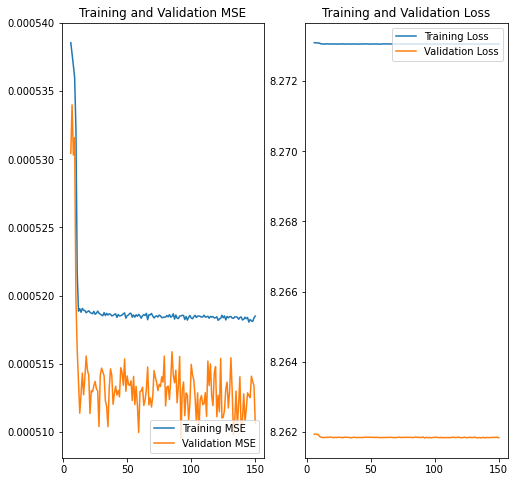

In [96]:
loss=history.history['loss']
val_loss=history.history['val_loss']

mae = history.history['mean_squared_error']
val_mae = history.history['val_mean_squared_error']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[5:], mae[5:], label='Training MSE')
plt.plot(epochs_range[5:], val_mae[5:], label='Validation MSE')
plt.legend(loc='lower right')
plt.title('Training and Validation MSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[5:], loss[5:], label='Training Loss')
plt.plot(epochs_range[5:], val_loss[5:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [97]:
vae.evaluate(test_scaled[100000:300000],test_scaled[100000:300000])

6250/6250 [==============================] - 19s 3ms/step - loss: 1.0348 - mean_squared_error: 5.1633e-04


[1.0348374843597412, 0.0005163276800885797]

### Compare results

In [98]:
vae.load_weights("model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5")

In [99]:
test_pred = vae.predict(test_scaled[100000:300000])
print(type(test_pred))

<class 'numpy.ndarray'>


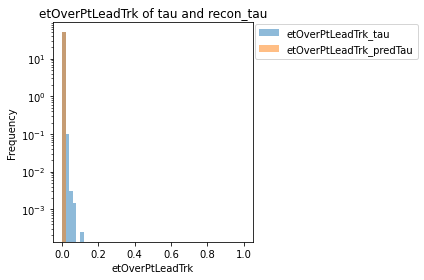

In [100]:
set_variable = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
                'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
xlow = [0, 0, 0, 0, 0, 0, 0, 0, 0]
xup = [1, 1, 1, 1, 1, 1, 1, 1, 1]
setted_var = 0 #btw 0 and 8
n_bins=50
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(train_scaled[100000:300000,setted_var], bins=n_bins , label=set_variable[setted_var]+'_tau', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]])
ax1.hist(test_pred[:,setted_var], bins=n_bins , label=set_variable[setted_var]+'_predTau', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and recon_tau")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')

<class 'numpy.ndarray'>
(200000, 2)


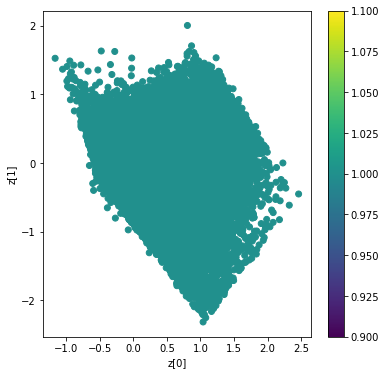

In [101]:
mean_encoded, logvar_encoded, z = encoder.predict(test_scaled[100000:300000], batch_size=64)
print(type(mean_encoded))
print(mean_encoded.shape)
plt.figure(figsize=(6, 6))
plt.scatter(mean_encoded[:, 0], mean_encoded[:, 1], c=test_labels[100000:300000])
#plt.plot(test_encoded[:, 0])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

### Using VAE on non-Tau objects

In [102]:
qcd_labels = np.zeros(len(test_scaled))

(400000, 2)
(400000, 2)


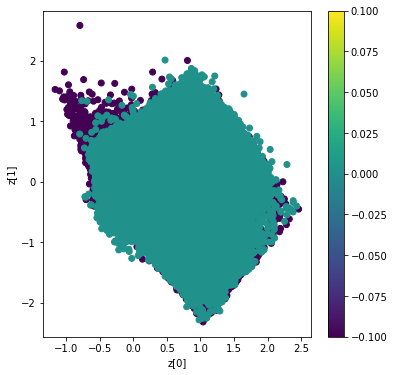

In [103]:
tau_mu_encoded, tau_logvar_encoded, z = encoder.predict(test_scaled[100000:500000], batch_size=64)
qcd_mu_encoded, qcd_logvar_encoded, z = encoder.predict(array_qcd_scaled[100000:500000,:], batch_size=64)
print(tau_mu_encoded.shape)
print(qcd_mu_encoded.shape)
plt.figure(figsize=(6, 6))
plt.scatter(tau_mu_encoded[:, 0], tau_mu_encoded[:, 1], c=test_labels[100000:500000])
plt.scatter(qcd_mu_encoded[:, 0], qcd_mu_encoded[:, 1], c=qcd_labels[100000:500000])
#plt.plot(test_encoded[:, 0])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [104]:
qcd_pred = vae.predict(array_qcd_scaled[100000:500000,:], batch_size = 64)
print(qcd_pred.shape)

(400000, 9)


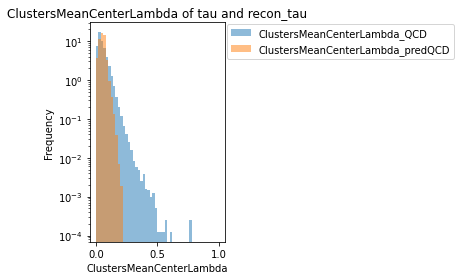

In [103]:
set_variable = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
                'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
xlow = [0, 0, 0, 0, 0, 0, 0, 0, 0]
xup = [1, 1, 1, 1, 1, 1, 1, 1, 1]
setted_var = 7 #btw 0 and 8
n_bins=50
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(array_qcd_scaled[100000:500000,setted_var], bins=n_bins , label=set_variable[setted_var]+'_QCD', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]])
ax1.hist(qcd_pred[:,setted_var], bins=n_bins , label=set_variable[setted_var]+'_predQCD', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and recon_tau")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')